<a href="https://colab.research.google.com/github/hasanzeynal/TensorFlow-Developer-Certificate/blob/main/03_CNN_and_Computer_Vision/computer_vision_and_cnn_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
import random
import os

from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, precision_score, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

#ignore all warnings
import warnings
warnings.filterwarnings(action= 'ignore')

# Introduction to CNN and Computer Vision
What we are gonna cover:
* Getting a DataSet for working on it(pizza_steak)
* Architecture of Convolutional Neural Network(CNN) in TensorFlow
* An end-to-end Binary Classification Problem
* Steps in Modelling with CNNs
* Creating a CNN model, compiling, fitting, and evaluating it
* An End-to-end Multiclass Classification Problem
* Making Predictions on Own Custom Images

# Importing Data for working on it(Pizza-Steak Images)

In [4]:
#get the data
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

#unzip the downloaded file
zip_ref = zipfile.ZipFile('pizza_steak.zip')
zip_ref.extractall()
zip_ref.close()

--2023-07-08 13:54:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 172.253.123.128, 173.194.210.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   154MB/s    in 0.7s    

2023-07-08 13:55:00 (154 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



## Inspect the dataset (means become one with it)

In [5]:
!ls pizza_steak

test  train


In [6]:
!ls pizza_steak/train

pizza  steak


In [7]:
!ls pizza_steak/train/pizza

1008104.jpg  1638227.jpg  2235981.jpg  2774899.jpg  3464027.jpg  576236.jpg
1008144.jpg  1646974.jpg  2236914.jpg  2775763.jpg  3464858.jpg  5764.jpg
1008844.jpg  1649108.jpg  2241448.jpg  2778214.jpg  3473991.jpg  579691.jpg
1008941.jpg  1649276.jpg  2247711.jpg  277963.jpg   3475936.jpg  593400.jpg
1011404.jpg  1652943.jpg  2253670.jpg  2785084.jpg  3478964.jpg  59445.jpg
102037.jpg   1654444.jpg  2255361.jpg  2793535.jpg  3479875.jpg  596494.jpg
1026922.jpg  1660415.jpg  2274117.jpg  27963.jpg    3479936.jpg  598381.jpg
1029698.jpg  1663749.jpg  2279642.jpg  2800325.jpg  3484590.jpg  604977.jpg
1033251.jpg  1665654.jpg  2280345.jpg  2811032.jpg  3493457.jpg  608085.jpg
1035854.jpg  166823.jpg   2285269.jpg  282013.jpg   349946.jpg	 618021.jpg
1038357.jpg  1670471.jpg  2285942.jpg  2821034.jpg  350358.jpg	 61822.jpg
1040878.jpg  1671531.jpg  228778.jpg   2821048.jpg  3505182.jpg  618348.jpg
1044524.jpg  1678284.jpg  2291093.jpg  2827938.jpg  3512070.jpg  625687.jpg
1044789.jpg  16810

In [8]:
#let's walk on data
for i, j, k in os.walk('/content/pizza_steak'):
  print(f"There are {len(j)} directories and  {len(k)} images in '{i}'")

There are 2 directories and  0 images in '/content/pizza_steak'
There are 2 directories and  0 images in '/content/pizza_steak/train'
There are 0 directories and  750 images in '/content/pizza_steak/train/pizza'
There are 0 directories and  750 images in '/content/pizza_steak/train/steak'
There are 2 directories and  0 images in '/content/pizza_steak/test'
There are 0 directories and  250 images in '/content/pizza_steak/test/pizza'
There are 0 directories and  250 images in '/content/pizza_steak/test/steak'


## To visualize our data, let's get the class names programmatically

In [9]:
#getting class names programmaticaly
data_dir = pathlib.Path("pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


In [10]:
#let's visualize random image
def view_random_image(folder_name,target_dir, target_class):   #target_dir means train or test, target_class means steak or pizza
  target_folder = folder_name + '/' + target_dir + '/' + target_class
  random_image = random.sample(os.listdir(target_folder), 1)[0]
  target = target_folder + '/' + random_image
  read_img = mpimg.imread(target)
  img = plt.imshow(read_img)
  plt.title(target_class)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  return img

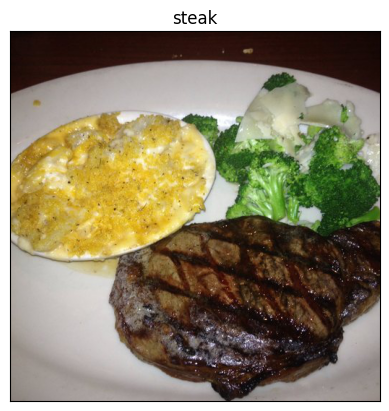

In [11]:
#get the steak images randomly
view_random_image(folder_name = 'pizza_steak',
                  target_dir= 'test',
                  target_class= 'steak')

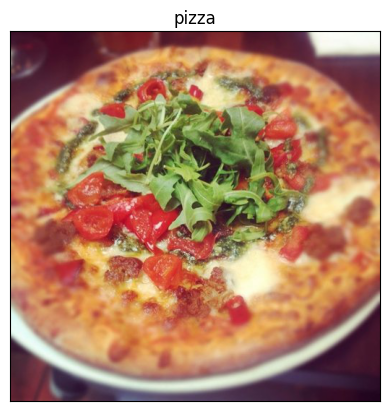

In [12]:
#get the pizza images randomly
view_random_image(folder_name = 'pizza_steak',
                  target_dir= 'train',
                  target_class= 'pizza')

#Building models
Some kind of different models architecture can be used for this binary classification problem and we will have look at all of them to figure out which type of model would be best fit our model.
* Non CNN models (Dense layers)
* CNN Models (Conv2d, Flatten, MaxPool, AvgPool layers)
* Improved Non CNN and CNN models


## Non CNN Model

In [13]:
#let's preproccess our images to the numerical data with same shapes(224,224,3)

#set the train and test directories
train_dir = 'pizza_steak/train'
test_dir = 'pizza_steak/test'

#create instance of ImageDataGenerator
train_gen = ImageDataGenerator(rescale = 1./256)
test_gen = ImageDataGenerator(rescale = 1./256)

#flow images from specified directory and apply data augmendation
train_data = train_gen.flow_from_directory(directory= train_dir,
                                           batch_size=32,
                                           target_size=(224, 224),
                                           class_mode='binary',
                                           seed=42)

test_data = test_gen.flow_from_directory(directory= test_dir,
                                         batch_size= 32,
                                         target_size= (224, 224),
                                         class_mode= 'binary',
                                         seed = 42)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [14]:
#let's create first simple model which is not cnn architecture(simple fully connected layers-Dense)

#set the random seed
tf.random.set_seed(42)

#create model
non_cnn_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape= (224, 224, 3)),
    tf.keras.layers.Dense(5, activation= 'relu'),
    tf.keras.layers.Dense(5, activation= 'relu'),
    tf.keras.layers.Dense(1, activation= 'sigmoid')
])

#compile the model
non_cnn_model_1.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                        optimizer = 'adam',
                        metrics = ['accuracy'])

#fit the model
non_cnn_model_1_history = non_cnn_model_1.fit(train_data,
                                              epochs= 5,
                                              steps_per_epoch= len(train_data),
                                              validation_data= test_data,
                                              validation_steps= len(test_data))

Epoch 1/5
47/47 [==============================] - 22s 442ms/step - loss: 0.6937 - accuracy: 0.4993 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 18s 376ms/step - loss: 0.6931 - accuracy: 0.4907 - val_loss: 0.6935 - val_accuracy: 0.4980
Epoch 3/5
47/47 [==============================] - 21s 452ms/step - loss: 0.6931 - accuracy: 0.4853 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 16s 352ms/step - loss: 0.6931 - accuracy: 0.4773 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 16s 337ms/step - loss: 0.6929 - accuracy: 0.4773 - val_loss: 0.6942 - val_accuracy: 0.5000


In [15]:
#get the summary
non_cnn_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 5)                 752645    
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 752,681
Trainable params: 752,681
Non-trainable params: 0
_________________________________________________________________


In [16]:
#get the plots for accuracy score and loss on both of train and validation subb sets
def view_plots(history):
  plt.figure(figsize=(16, 9))
  #get the accuracy plot
  fig_1 = pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
  #get the loss plot
  fig_2 = pd.DataFrame(history.history)[['loss','val_loss']].plot()
  plt.show()
  return fig_1, fig_2

<Figure size 1600x900 with 0 Axes>

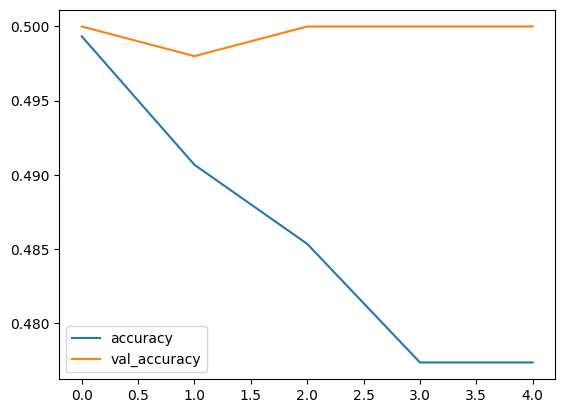

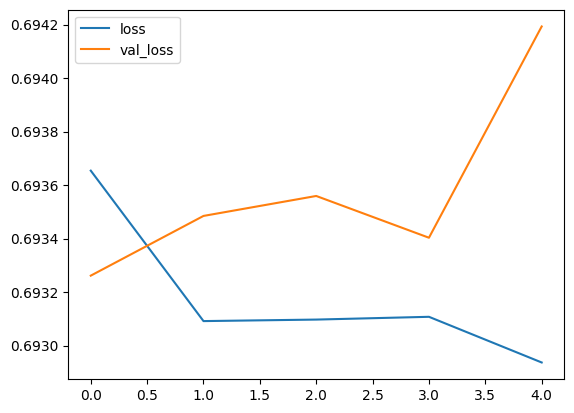

(<Axes: >, <Axes: >)

In [17]:
view_plots(non_cnn_model_1.history)

## Non CNN Model 2

In [18]:
#let's create second model with full connected layers

#set the seed
tf.random.set_seed(42)

#create the model
non_cnn_model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape= (224, 224, 3)),
    tf.keras.layers.Dense(100, activation= 'relu'),    #number of units per hidden layer is increased to 100
    tf.keras.layers.Dense(100, activation= 'relu'),
    tf.keras.layers.Dense(100, activation= 'relu'),    #adding more hidden layer
    tf.keras.layers.Dense(1, activation= 'sigmoid')
])

#compile the model
non_cnn_model_2.compile(loss = 'binary_crossentropy',
                        optimizer = tf.keras.optimizers.Adam(lr = 0.001),
                        metrics = ['accuracy'])

#fit the model
non_cnn_model_2_history = non_cnn_model_2.fit(train_data,
                                              epochs=5,
                                              steps_per_epoch= len(train_data),
                                              validation_data = test_data,
                                              validation_steps= len(test_data))

Epoch 1/5
47/47 [==============================] - 30s 617ms/step - loss: 2.8210 - accuracy: 0.6393 - val_loss: 0.5157 - val_accuracy: 0.7560
Epoch 2/5
47/47 [==============================] - 28s 597ms/step - loss: 0.7451 - accuracy: 0.7053 - val_loss: 0.4480 - val_accuracy: 0.7960
Epoch 3/5
47/47 [==============================] - 26s 555ms/step - loss: 0.6249 - accuracy: 0.7233 - val_loss: 0.9352 - val_accuracy: 0.6400
Epoch 4/5
47/47 [==============================] - 27s 566ms/step - loss: 0.5322 - accuracy: 0.7627 - val_loss: 0.7674 - val_accuracy: 0.5780
Epoch 5/5
47/47 [==============================] - 25s 529ms/step - loss: 0.5177 - accuracy: 0.7667 - val_loss: 0.4764 - val_accuracy: 0.7620


In [19]:
#get the summary for the second layer
non_cnn_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_3 (Dense)             (None, 100)               15052900  
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


<Figure size 1600x900 with 0 Axes>

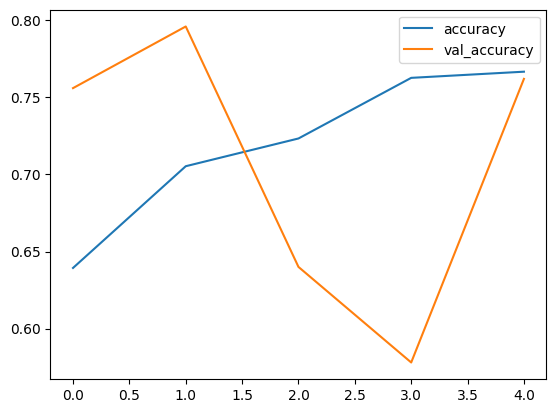

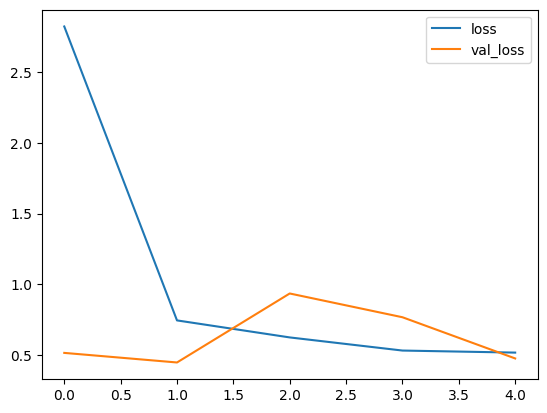

(<Axes: >, <Axes: >)

In [20]:
view_plots(non_cnn_model_2_history)

## CNN Model 1

In [ ]:
#let's create the cnn model 1 and it is gonna be a little bit small and simple(same as TinyVGG) 2 conv2d,maxpool, 2 conv2d, max_pool, flatten, dense

#set the random_state
tf.random.set_seed(42)

#create the model
cnn_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 10,
                           kernel_size= 3,
                           activation= 'relu',input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(10, 3, activation= 'relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), padding= 'valid'),
    tf.keras.layers.Conv2D(10, 3, activation= 'relu'),
    tf.keras.layers.Conv2D(10, 3, activation= 'relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation= 'sigmoid')
])

#compile the model
cnn_model_1.compile(loss= 'binary_crossentropy',
                    optimizer= tf.keras.optimizers.Adam(),
                    metrics= ['accuracy'])

#fit the model
cnn_model_1_history = cnn_model_1.fit(train_data,
                epochs= 5,
                steps_per_epoch= len(train_data),
                validation_data= test_data,
                validation_steps= len(test_data))

Epoch 1/5
29/47 [=================>............] - ETA: 45s - loss: 0.6020 - accuracy: 0.6645

In [ ]:
#if you wondering what is the len(train_data) which is implemented for steps_per_epoch
len(train_data)

In [ ]:
#and now,probably you are wondering where 47 comes from?
1500 / 32   #which means 1500 is train_images and 32 is batch_size

In [ ]:
#view the plots(loss and accuracy)
view_plots(cnn_model_1_history)

In [ ]:
cnn_model_1.summary()

## CNN Model 2 on Augmented Data

In [ ]:
#let's create a model on augmented data to see how our model is gonna change

#applying ImageDataGenerator with 1/250 rescale
test_gen = ImageDataGenerator(rescale= 1./256)
train_gen_augmented = ImageDataGenerator(rescale= 1./256,
                                         rotation_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True,
                                         shear_range=0.2,
                                         width_shift_range = 0.2,
                                         height_shift_range = 0.2)

#creating test data and augmented train data
image_size = (224, 224)
test_data = test_gen.flow_from_directory(directory = test_dir,
                                         target_size = image_size,
                                         batch_size = 32,
                                         class_mode = 'binary',
                                         seed = 42)

augmented_train_data = train_gen_augmented.flow_from_directory(directory = train_dir,
                                                               target_size = image_size,
                                                               batch_size = 32,
                                                               class_mode = 'binary',
                                                               seed = 42)


#let's create our 4th model on the augmented data

#set the random seed
tf.random.set_seed(42)

#create the model(we are gonne create our model as TinyVGG Net)
aug_cnn_model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters= 10,
                           kernel_size= 3,
                           activation= 'relu',
                           input_shape= (224, 224, 3)),
    tf.keras.layers.Conv2D(10,3,activation = 'relu'),
    tf.keras.layers.MaxPool2D(pool_size= (3,3)),
    tf.keras.layers.Conv2D(10, 3, activation= 'relu'),
    tf.keras.layers.Conv2D(10, 3, activation= 'relu'),
    tf.keras.layers.MaxPool2D(pool_size=(3,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation= 'sigmoid')
])

#compile the model
aug_cnn_model_2.compile(loss= 'binary_crossentropy',
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics = ['accuracy'])

#fit tht model
aug_cnn_model_2_history = aug_cnn_model_2.fit(augmented_train_data,
                                              epochs= 10,
                                              steps_per_epoch = len(augmented_train_data),
                                              validation_data = test_data,
                                              validation_steps = len(test_data))

In [ ]:
len(test_data), 500/32

In [ ]:
view_plots(aug_cnn_model_2_history)

In [ ]:
aug_cnn_model_2.summary()

## CNN Model 2 on Augmented Shuffled Data

In [ ]:
#let's create our 5th model with suffle data

#create image data generator
aug_train_gen = ImageDataGenerator(rescale = 1./256,
                               height_shift_range=0.2,
                               width_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip = True)

test_gen = ImageDataGenerator(rescale = 1./256)

#change opur images to the numbers
aug_shuffled_train_data = aug_train_gen.flow_from_directory(directory = train_dir,
                                                            target_size = image_size,
                                                            batch_size = 32,
                                                            class_mode = 'binary',
                                                            shuffle= True)   #adding shuffle= True

test_data = test_gen.flow_from_directory(directory = test_dir,
                                         target_size = image_size,
                                         batch_size = 32,
                                         class_mode = 'binary')

#creating a model
aug_sh_cnn_model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(10, 3, activation='relu', input_shape = (224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(3,3)),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(3,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation= 'sigmoid')
])

#compile the model
aug_sh_cnn_model_3.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ['accuracy'])

#fit the model
aug_sh_cnn_model_3_history = aug_sh_cnn_model_3.fit(aug_shuffled_train_data,
                                                    epochs= 5,
                                                    steps_per_epoch= len(aug_shuffled_train_data),
                                                    validation_data = test_data,
                                                    validation_steps= len(test_data))

In [ ]:
#view the plots
view_plots(aug_sh_cnn_model_3_history)

In [ ]:
aug_sh_cnn_model_3.summary()

## Making Prediction on the Trained Model with the Custom Images


In [ ]:
#let's remind class names
class_names

In [ ]:
#creating function to visualize our predictions
def get_predictions(data_type,class_name):
  directory = 'pizza_steak/' + data_type + '/' + class_name
  image = random.sample(os.listdir(directory),1)[0]
  image_directory = directory + '/' +image
  reading_image = mpimg.imread(image_directory)
  resized_image = tf.image.resize(reading_image,[224,224])
  prediction = cnn_model_1.predict(tf.expand_dims(resized_image, axis= 0))
  title = class_names[int(prediction)]
  img = plt.imshow(reading_image)
  if title == class_name:
    c = 'g'
  else:
    c = 'r'
  plt.xlabel("Prediction: {},True Label: {}".format(title,
                                                    class_name),
                                                    color = c)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  return img

In [ ]:
get_predictions(data_type = 'train',class_name = 'pizza')

In [ ]:
get_predictions(data_type = 'train',class_name = 'pizza')

In [ ]:
get_predictions(data_type = 'train',class_name = 'pizza')

In [ ]:
get_predictions(data_type = 'train',class_name = 'steak')

In [ ]:
get_predictions(data_type = 'train',class_name = 'steak')

In [ ]:
get_predictions(data_type = 'train',class_name = 'steak')

#Multiclass Classification in TensorFlow

In [ ]:
# Download zip file of 10_food_classes images
# See how this data was created - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [ ]:
#getting directory of train data and test data
train_dir = '/content/10_food_classes_all_data/train'
test_dir = '/content/10_food_classes_all_data/test'

In [ ]:
view_random_image('10_food_classes_all_data','train',random.sample(os.listdir(train_dir),1)[0])

In [ ]:
view_random_image('10_food_classes_all_data','train',random.sample(os.listdir(train_dir),1)[0])

In [ ]:
view_random_image('10_food_classes_all_data','train',random.sample(os.listdir(train_dir),1)[0])

In [ ]:
view_random_image('10_food_classes_all_data','train',random.sample(os.listdir(train_dir),1)[0])

## Multiclass Model 1

In [2]:
#let's create a first Multiclass Classification model

#image data generator
train_gen = ImageDataGenerator(rescale = 1./256)
test_gen = ImageDataGenerator(rescale = 1./256)

#let's create our images to the numbers
train_data = train_gen.flow_from_directory(directory= train_dir,
                                           batch_size=32,
                                           class_mode='categorical',
                                           target_size=(224,224),
                                           seed = 42)

test_data = test_gen.flow_from_directory(directory= test_dir,
                                         batch_size=32,
                                         class_mode='categorical',
                                         target_size=(224,224),
                                         seed = 42)

#set the random seed
tf.random.set_seed(42)

#create the model
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(10, 3, activation= 'relu'),
    tf.keras.layers.Conv2D(10, 3, activation= 'relu'),
    tf.keras.layers.MaxPool2D(pool_size=(3,3)),
    tf.keras.layers.Conv2D(10, 3, activation= 'relu'),
    tf.keras.layers.Conv2D(10, 3, activation= 'relu'),
    tf.keras.layers.MaxPool2D(pool_size=(3,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation= 'sigmoid')
])

#compile the model
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

#fit the model
model_1_history = model_1.fit(train_data,
            epochs= 5,
            steps_per_epoch = len(train_data),
            validation_data = test_data,
            validation_steps = len(test_data))

NameError: ignored

## Multiclass Model 2 on Augmented Data

In [219]:
#let's create a second Multiclass Classification model on augmented data

#image data generator
train_gen = ImageDataGenerator(rescale = 1./256,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               zoom_range = 0.2,
                               shear_range = 0.2,
                               horizontal_flip = True)
test_gen = ImageDataGenerator(rescale = 1./256)

#let's create our images to the numbers
train_data = train_gen.flow_from_directory(directory= train_dir,
                                           batch_size=32,
                                           class_mode='categorical',
                                           target_size=(224,224),
                                           seed = 42)

test_data = test_gen.flow_from_directory(directory= test_dir,
                                         batch_size=32,
                                         class_mode='categorical',
                                         target_size=(224,224),
                                         seed = 42)

#set the random seed
tf.random.set_seed(42)

#create the model
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(10, 3, activation= 'relu'),
    tf.keras.layers.Conv2D(10, 3, activation= 'relu'),
    tf.keras.layers.MaxPool2D(pool_size=(3,3)),
    tf.keras.layers.Conv2D(10, 3, activation= 'relu'),
    tf.keras.layers.Conv2D(10, 3, activation= 'relu'),
    tf.keras.layers.MaxPool2D(pool_size=(3,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation= 'sigmoid')
])

#compile the model
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

#fit the model
model_1.fit(train_data,
            epochs= 5,
            steps_per_epoch = len(train_data),
            validation_data = test_data,
            validation_steps = len(test_data))

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/5
235/235 [==============================] - 128s 536ms/step - loss: 2.2318 - accuracy: 0.1603 - val_loss: 2.1186 - val_accuracy: 0.1960
Epoch 2/5
235/235 [==============================] - 126s 538ms/step - loss: 2.1379 - accuracy: 0.2165 - val_loss: 2.0202 - val_accuracy: 0.2684
Epoch 3/5
235/235 [==============================] - 134s 572ms/step - loss: 2.0699 - accuracy: 0.2592 - val_loss: 2.0485 - val_accuracy: 0.2588
Epoch 4/5
235/235 [==============================] - 135s 576ms/step - loss: 1.9988 - accuracy: 0.2935 - val_loss: 1.8491 - val_accuracy: 0.3512
Epoch 5/5
235/235 [==============================] - 150s 637ms/step - loss: 1.9548 - accuracy: 0.3107 - val_loss: 1.7749 - val_accuracy: 0.3920


## Making Predictions and Visualizing them

In [ ]:
def get_predictions_multi():
  image_dir = random.sample(os.listdir('/content/10_food_classes_all_data/test'),1)[0]

In [ ]:
'10_food_classes_all_data/' + 'test' + '/' +

In [220]:
random.sample(os.listdir('/content/10_food_classes_all_data/test'),1)[0]

['ramen',
 'chicken_wings',
 'pizza',
 'grilled_salmon',
 'steak',
 'chicken_curry',
 'ice_cream',
 'sushi',
 'hamburger',
 'fried_rice']